### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(42)
np.random.seed(42)

/home/gustavo/anaconda3/envs/gustavo/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Load 2013 data


In [3]:
# Load 2013 data (training set)
df_2013 = pd.read_excel(r"./preprocessed_2013.xlsx")

# Excluding notes classified as "automatic"
df_2013 = df_2013[df_2013.Category2.isin(['empty', 'automatic']) == False]
df_2013['Score'] = df_2013['Proc1SVM']

df_2013_sorted = df_2013.sort_values(by=['Score'], ascending=False)
df_2013_sorted['CleanedSeqN'] = np.arange(len(df_2013_sorted))

# Excluding unused columns
mr_2013 = df_2013.drop(['Category', 'Proc1SVM', 'Score'], inplace=False, axis=1)
mr_2013 = mr_2013.rename(columns={'Category2': 'label'})

## Load 2020 data

In [ ]:
# Load 2020 data (test set)
df_2020 = pd.read_excel(r"./preprocessed_2020.xlsx")

# Excluding notes classified as "automatic"
df_2020 = df_2020[df_2020.Category2.isin(['empty', 'automatic']) == False]
df_2020['Score'] = df_2020['Proc1SVM']

df_2020_sorted = df_2020.sort_values(by=['Score'], ascending=False)
df_2020_sorted['CleanedSeqN'] = np.arange(len(df_2020_sorted))

# Excluding unused columns
mr_2020 = df_2020.drop(['Category', 'Proc1SVM', 'Score'], inplace=False, axis=1)
mr_2020 = mr_2020.rename(columns={'Category2': 'label'})

## Prepare data for calculations

In [ ]:
mr_2013["binary_label"] = mr_2013["label"].map({'positives':1, 'negatives':0})
mr_2020["binary_label"] = mr_2020["label"].map({'positives':1, 'negatives':0})

labels_2013_sorted = mr_2013['binary_label'] 
labels_2020_sorted = mr_2020['binary_label'] 

n = min(len(labels_2013_sorted), len(labels_2020_sorted))
labels_2013_sorted = labels_2013_sorted[:n]
labels_2020_sorted = labels_2020_sorted[:n]


### Precision@K

Precision@K is a metric that measures how many of the top-ranked predictions are true positives. It is particularly useful when early ranks matter most, which is the case when attempting to reduce manual review or to improve the yield of manual review.

---


### Calculations for the Precision@K metric

Given a binary label array (`1 = positive`, `0 = negative`) ranked by a given ordinal scale, the formula for the Precision@K is given by the following rolling widow:

```python
precision_at_k = np.mean(sorted_labels[:K])


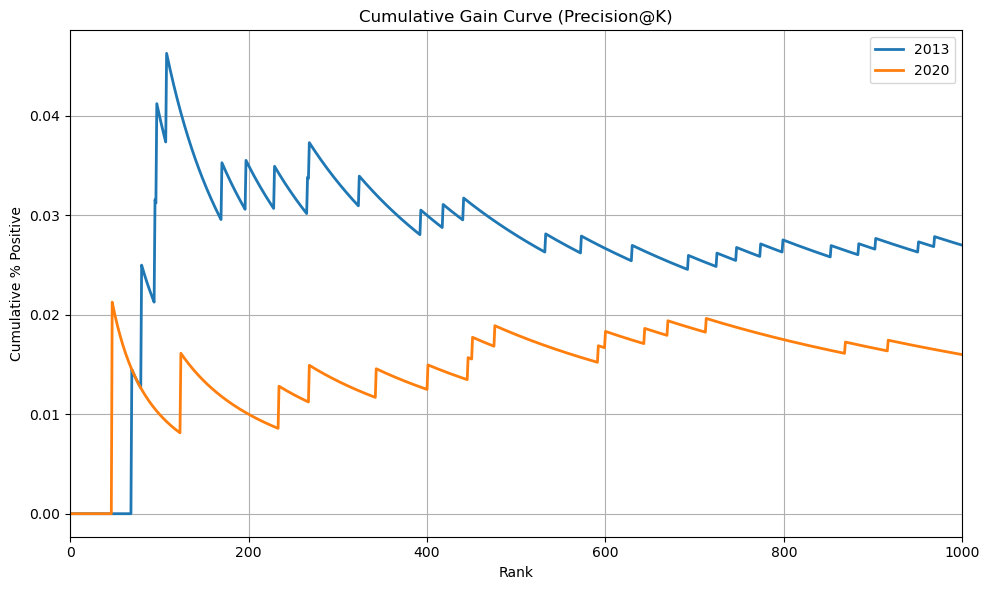

In [ ]:
# Cumulative gain
ks = np.arange(1, n+1)
prec_2013 = np.cumsum(labels_2013_sorted) / ks
prec_2020 = np.cumsum(labels_2020_sorted) / ks
cum_diff = prec_2013 - prec_2020

# Cumulative gain curve
plt.figure(figsize=(10, 6))
plt.plot(ks, prec_2013, label='2013', linewidth=2)
plt.plot(ks, prec_2020, label='2020', linewidth=2)
plt.xlabel('Rank')
plt.ylabel('Cumulative % Positive')
plt.title('Cumulative Gain Curve (Precision@K)')
plt.legend()
plt.grid(True)
plt.xlim(0, 1000)
plt.tight_layout()
plt.show()

### Permutation test

A permutation test is a distribution-free alternative to answer the following question:

> “Could the difference I see have arisen by chance if the two groups presented the same proportion of positives along the ranks?”

Instead of relying on asymptotic formulas (z-tests, χ², etc.) that may depend on distribution assumptions, we simulate the null hypothesis by repeatedly shuffling the group labels and recalculating the statistic of interest.  

---

### Why use a Permutation Test here?

Classical tests, such as the Kolmogorov-Smirnoff and Mann-Whitney tests, don’t give special weight to early ranks, and normal-approximation p-values can be unfit for rare events.

A permutation test targets exactly the statistic we care about (difference in Precision@K), while making no distributional assumptions about labels or any underlying variable. 

---

### How does it work?

1. Observed statistic  
  $$ 
   \Delta^* \;=\; \text{Precision}_{2013}@K \;-\; \text{Precision}_{2020}@K
   $$

2. Generate the null distribution  
   - Stack all labels together.  
   - Shuffle (permute) them.  
   - Split the shuffled array back into two groups of the same sizes as 2013 and 2020.  
   - Recompute $\Delta$ and call it $\Delta_{\text{perm}}$ for that permutation.  
   - Repeat many times (e.g., 10.000).

3. Compute p-value  
   $$
   p = \frac{\#\{\Delta_{\text{perm}} \ge \Delta^*\}}{\text{\# permutations}}
   $$

4. Interpretation  
   A small p-value (e.g., < 0.05) means that observing a difference at least as large as Δ\* is unlikely if the two years had identical early-rank precision — supporting the claim of a real shift.

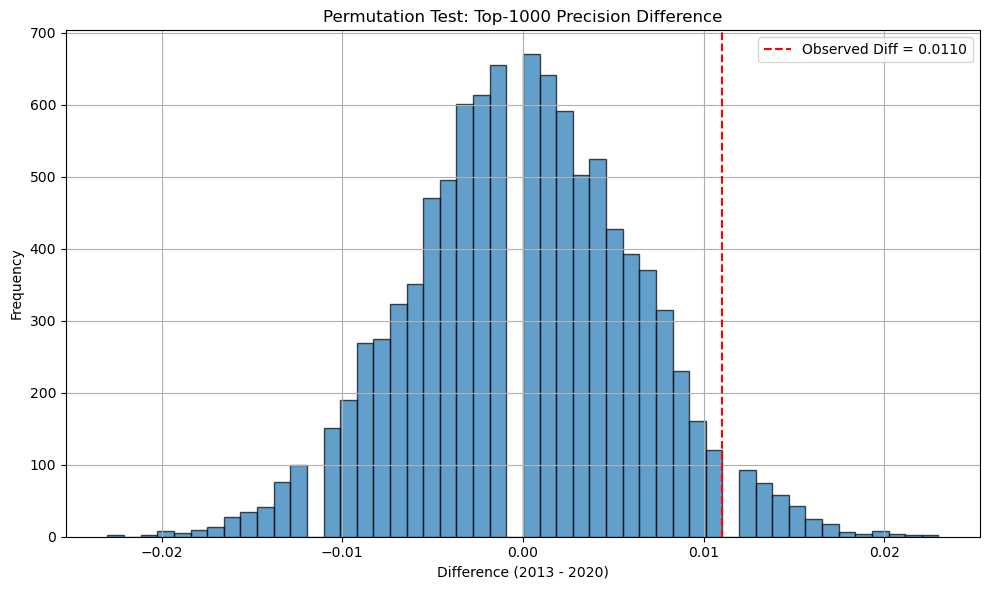

In [ ]:
# Permutation test
def permutation_test_top_k(labels1, labels2, k=1000, n_permutations=10000, seed=42):
    np.random.seed(seed)
    observed_diff = np.mean(labels1[:k]) - np.mean(labels2[:k])
    combined = np.concatenate([labels1, labels2])
    diffs = []
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        sample1 = combined[:n]
        sample2 = combined[n:]
        diff = np.mean(sample1[:k]) - np.mean(sample2[:k])
        diffs.append(diff)
    p_value = np.mean(np.array(diffs) >= observed_diff)
    return observed_diff, p_value, diffs

observed_diff, p_val, null_distribution = permutation_test_top_k(labels_2013_sorted, labels_2020_sorted, k=1000)

# Perrmutation test results
plt.figure(figsize=(10, 6))
plt.hist(null_distribution, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(observed_diff, color='red', linestyle='--', label=f'Observed Diff = {observed_diff:.4f}')
plt.title('Permutation Test: Top-1000 Precision Difference')
plt.xlabel('Difference (2013 - 2020)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
print(f"Observed difference in top-1000 precision: {observed_diff:.4f}")
print(f"P-value from permutation test: {p_val:.4f}")


Observed difference in top-1000 precision: 0.0110
P-value from permutation test: 0.0457
